#LAB 6: Style transfer




# Neural Stylization with Pytorch
## Introduction


<img src="http://drive.google.com/uc?export=view&id=1crqAv5aoJ3uMSDFT99l6VuzY3VUlF_C7" alt="no_image" style="width: 900px;"/>


This lab introduces a Neural Algorithm of Artistic Style that can separate and recombine the image content and style of natural images. The algorithm takes two images, a content-image, and a style-image, and generates the optimized image to resemble the content of the content-image and the artistic style of the style-image.


**Main idea**

To transfer the style image $\textit{I}_s$ onto a content image $\textit{I}_c$ we synthesize a new image that simultaneously matches the content representation of $\textit{I}_c$ and the style representation of $\textit{I}_s$ (Fig). Thus we jointly minimize the distance of the feature representations of a white noise image from the content representation of the photograph in one layer and the style representation of the painting defined on a number of layers of the Convolutional Neural Network.
<img src="http://drive.google.com/uc?export=view&id=1BhfqqQEMn3AyHpc6fB-shQDlU-tQeoLz" alt="no_image" style="width: 900px;"/>

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

from PIL import Image
import numpy as np

from torchvision import datasets
from torch.utils.data import DataLoader


In [10]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" # Arrange GPU devices starting from 0 
os.environ["CUDA_VISIBLE_DEVICES"]= "3" # Set the GPU 3 to use

In [11]:
import random
# Set the random seed for reproducibility
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("Random seed set to:", seed)

Random seed set to: 0


In [12]:
import sys
import platform

print("Python version")
print(sys.version_info)

print("\nOS information")
print(platform.platform())

print("\nIs GPU available?")
print(torch.cuda.is_available())

# print("\nCPU information")
# !cat /proc/cpuinfo

# print("\nMemory information")
# !cat /proc/meminfo

if torch.cuda.is_available():
    print("\nGPU information")
    !nvidia-smi
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f"\ndevice={device}")
# os.chdir('/home/dlpro24/24-2DLProgramming/huch0')
print(os.getcwd())

Python version
sys.version_info(major=3, minor=11, micro=7, releaselevel='final', serial=0)

OS information
macOS-15.0.1-arm64-arm-64bit

Is GPU available?
False

device=mps
/Users/chiyeong/Documents/projects/Deep_Learning_Programming/Labs/Lab6-Style Transfer


**Style and content image**

In [13]:
style_img_name = "lab6/style/mosaic.jpg"
content_img_name = "lab6/content/Tuebingen_Neckarfront.jpg"

In [14]:
style_img = Image.open(style_img_name)
content_img = Image.open(content_img_name)

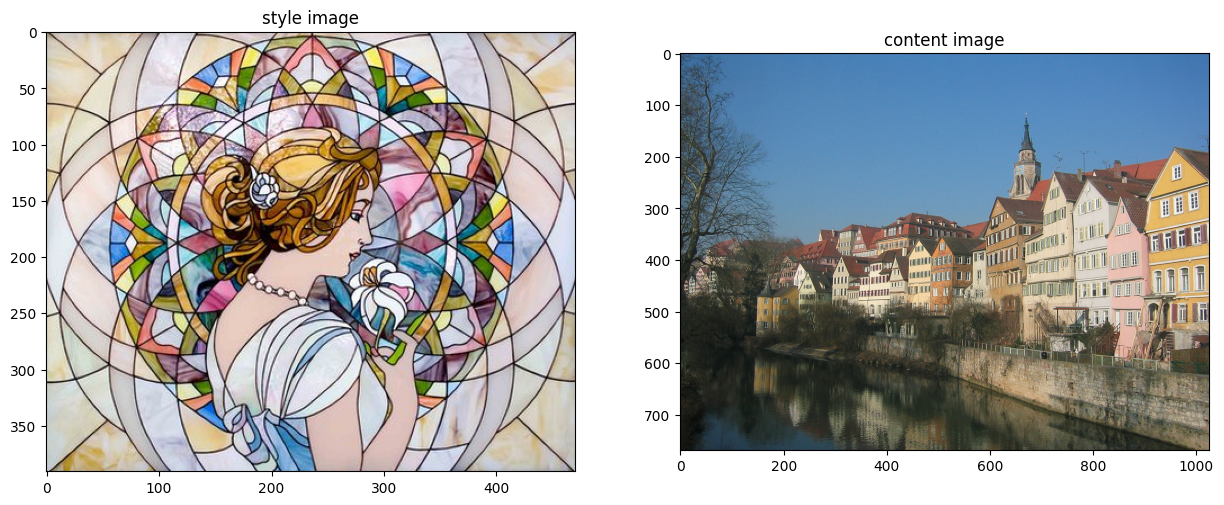

In [15]:
plt.figure(figsize = (15,15))
plt.subplot(1,2,1)
plt.title('style image')
plt.imshow(style_img)
plt.subplot(1,2,2)
plt.title('content image')
plt.imshow(content_img)

### Style representation

To obtain a representation of the style of an input image, we use a feature space designed to capture texture information. This feature space can be built on top of the filter responses in any layer of the network. It consists of the correlations between the different filter responses, where the expectation is taken over the spatial extent of the feature maps. These feature correlations are given by the Gram matrix $\mathit{G} \in \mathcal{R}^{\mathit{N_l}  \times  \mathit{N_l}}$, where $\mathit{G^l_{ij}}$ is the inner product between the vectorised feature maps $i$ and $j$ in layer $l$:

### <center> ${\mathit{G^l_{ij}} = \sum_{k}{F^l_{ik}F^l_{jk}}}$ </center>

In [16]:
def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram

### Deep image representations

In this work we show how the generic feature representations learned by high-performing Convolutional Neural Networks can be used to independently process and manipulate the content and the style of natural images.

The image reperesentations were generated on the basis of the VGG network, which was trained to perform object recognition and localization. We use the feature space provided by the 16 convolutional and 5 pooling layers of the 19-layer VGG network.

In [17]:
import torchvision.models.vgg as vgg

class LossNetwork(torch.nn.Module):
    def __init__(self):
        super(LossNetwork, self).__init__()
        # get vgg network
        self.vgg_layers = vgg.vgg19(pretrained=True).features


    def forward(self, x, layer_name):
        output = {}
        for name, module in self.vgg_layers._modules.items():
            x = module(x)
            if name in layer_name:
                output[layer_name[name]] = x
        return output

In [18]:
# loss_net = LossNetwork().cuda()
loss_net = LossNetwork().to(device)
for param in loss_net.parameters():
    param.requires_grad = False

/Users/chiyeong/Documents/projects/Deep_Learning_Programming/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/chiyeong/Documents/projects/Deep_Learning_Programming/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Content representation is on layer ‘conv4 2’ and the style representation is on layers ‘conv1 1’, ‘conv2 1’, ‘conv3 1’, ‘conv4 1’ and ‘conv5 1’

In [19]:
style_layer_name = {
    '1': "conv1-1",
    '6': "conv2-1",
    '11': "conv3-1",
    '20': "conv4-1",
    '29': "conv5-1"
}

content_layer_name = {
    '22': "conv4-2"
}

**Pre and post processing for images**

In [20]:

img_size = 512
prep = transforms.Compose([transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                        std=[1,1,1]),
])

post = transforms.Compose([
    transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], #add imagenet mean
                        std=[1,1,1]),
    transforms.Lambda(lambda x: torch.clamp(x,0,1)),
    transforms.ToPILImage()
])

In [21]:
# content = prep(content_img).cuda().unsqueeze(0)
# style = prep(style_img).cuda().unsqueeze(0)
content = prep(content_img).to(device).unsqueeze(0)
style = prep(style_img).to(device).unsqueeze(0)

out_img = content.clone()
out_img.requires_grad = True


criterion = nn.MSELoss()
style_gt = [gram_matrix(f).detach() for f in loss_net(style, style_layer_name).values()]
content_gt = [A.detach() for A in loss_net(content, content_layer_name).values()]

show_iter = 50
optimizer = optim.LBFGS([out_img])
n_iter = [0]

**Hyper parameters**

In [22]:
alpha = 1e0
beta = 1e7
max_iter = 500

**Optimizing image**

In [23]:
while n_iter[0] <= max_iter:

    def closure():
        optimizer.zero_grad()

        style_layers = [gram_matrix(f) for f in loss_net(out_img, style_layer_name).values()]
        content_layers = [f for f in loss_net(out_img, content_layer_name).values()]

        style_loss = 0
        for i in range(len(style_layers)):
            style_loss += criterion(style_layers[i], style_gt[i])

        content_loss = criterion(content_layers[0], content_gt[0])

        loss = alpha * content_loss + beta * style_loss
        loss.backward()
        n_iter[0]+=1
        #print loss
        if n_iter[0]%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.item()))

        return loss

    optimizer.step(closure)

#display result

Iteration: 50, loss: 9.147172
Iteration: 100, loss: 6.403856
Iteration: 150, loss: 5.697572
Iteration: 200, loss: 5.358752
Iteration: 250, loss: 5.157891
Iteration: 300, loss: 5.027277
Iteration: 350, loss: 4.940482
Iteration: 400, loss: 4.875125
Iteration: 450, loss: 4.826088
Iteration: 500, loss: 4.786308


**Visualize result images**

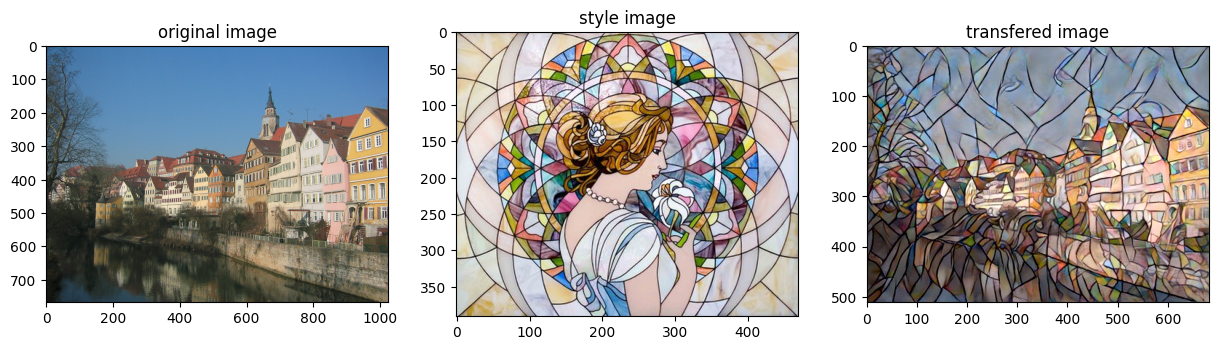

In [24]:
out_img_hr = post(out_img.data[0].cpu().squeeze())

plt.figure(figsize = (15,15))

plt.subplot(1,3,1)
plt.title('original image')
plt.imshow(content_img)
plt.subplot(1,3,2)
plt.title('style image')
plt.imshow(style_img)
plt.subplot(1,3,3)
plt.title('transfered image')
plt.imshow(out_img_hr)
plt.show()



# Perceptual Losses for Style Transfer with Pytorch


**Main idea**

Previous method produces high-quality results, but is computationally expensive since each step of the optimization problem requires a forward and backward pass through the pretrained network. To overcome this computational burden, we train a feed-forward network to quickly approximate solutions to their optimization problem.
<img src="http://drive.google.com/uc?export=view&id=1GFM9l-63SsOFYHP-g2WNN2T6zNDdD09Z" alt="no_image" style="width: 900px;"/>


$\mathcal{L}_{total} = \alpha\sum_{}{\mathcal{l}_{content}} + \beta\sum_{}{\mathcal{l}_{style}} + \gamma\mathcal{l}_{TV}$

- $\mathcal{l}_{content}^{\phi,j} = ||\phi_j(\hat{y}) - \phi_j(y)||^2_2$, $\phi$ represents vgg feature

- $\mathcal{l}_{style}^{\phi,j} = ||G^{\phi}_{j}(\hat{y}) - G^{\phi}_{j}(y)||^2_F$, $G$ represents gram matrix.

- $\mathcal{l}_{TV}(y) = \sum_{i,j}{|y_{i+1,j}-y_{i,j}|+|y_{i,j+1}-y_{i,j}|}$



**Data loader**

In [ ]:
data_root = "lab6/train"
image_size = 224
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])])

train_dataset = datasets.ImageFolder(data_root, transform)

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

### 1.1 Write code (Image Transform Net)

<img src="http://drive.google.com/uc?export=view&id=1OQzOwfRgpncvvBCwUCJbShYQGBElUqjW" alt="no_image" style="width: 400px;"/>

##### Residual block (channel, x)
- Conv 1: $3\times3$ Conv(in: channel, out: channel, padding: 1) with reflection padding
- Instance Norm
- Relu
- Conv 2: $3\times3$ Conv(in: channel, out: channel, padding: 1) with reflection padding
- Instance Norm
- Residual Connection

#### ImageTransformNet
- Conv $9\times9$  (in: 3, out: 32, padding: 4) with reflection padding
- Instance Norm
- Relu
- Conv $3\times3$  (in: 32, out: 64, padding: 1, **stride: 2**) with reflection padding
- Instance Norm
- Relu
- Conv $3\times3$  (in: 64, out:128, padding: 1, **stride: 2**) with reflection padding
- Instance Norm
- Relu
- 5 Residual block(channel: 128)
- $2\times$ Nearest Upsample
- Conv $3\times3$  (in: 128, out:64, padding: 1) with reflection padding
- Instance Norm
- Relu
- **$2\times$ Nearest Upsample**
- Conv $3\times3$  (in: 64, out:32, padding: 1) with reflection padding
- Instance Norm
- Relu
- Conv $9\times9$  (in: 32, out:3, padding: 4) with reflection padding



In [ ]:
class ImageTransformNet(torch.nn.Module):
    def __init__(self):
        super(ImageTransformNet, self).__init__()
        #############
        # CODE HERE #
        #############

    def forward(self, X):
        #############
        # CODE HERE #
        #############

class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(
            in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out


class ResidualBlock(torch.nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.conv2 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in2 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.relu(self.in1(self.conv1(x)))
        out = self.in2(self.conv2(out))
        out = out + residual
        return out


class UpsampleConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        if upsample:
            self.upsample_layer = torch.nn.Upsample(
                mode='nearest', scale_factor=upsample)
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(
            in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = self.upsample_layer(x_in)
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out

In [ ]:
transformer = ImageTransformNet().cuda()

### 1.2 Find style and content representation layers in loss net

In [ ]:
style_layer_name = {
   #############
    # CODE HERE #
    #############
}

content_layer_name = {
    #############
    # CODE HERE #
    #############
}

In [ ]:
style = transform(style_img).cuda().unsqueeze(0)
style_gt = [gram_matrix(f).detach() for f in loss_net(style, style_layer_name).values()]

**Hyper parameters**

In [ ]:
# You may adjust hyper paramters
alpha = 1e0
beta = 1e4
gamma = 1e-5

LR = 1e-3
steps = 2000
optimizer = optim.Adam(transformer.parameters(), LR)

### 1.3 Train the image transformNet

- Print total loss, content loss, style loss and total variation loss for every 50 iterations
- Style loss should contain all of the layers listed above
- Use alpha, beta, gamma as coefficient

In [ ]:
transformer.train()
n_iter = 0
class Found(Exception): pass
try:
    while True:
        for x, _ in train_loader:

            n_iter += 1
            optimizer.zero_grad()

            # x = x.cuda()
            x = x.to(device)
            # Image Transform
            y = transformer(x)


            #############
            # CODE HERE #
            #############

            # Content Loss
            content_x =
            content_y =

            content_loss =

            # Style Loss
            style_y =

            style_loss = 0.
            for i in range(len(style_y)):
                style_loss +=

            # Total Variation Loss
            tv_loss =  gamma * (
                torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) +
                torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :])))


            total_loss = content_loss + style_loss + tv_loss
            total_loss.backward()

            total_running_loss += total_loss.item()
            style_running_loss += style_loss.item()
            content_running_loss += content_loss.item()
            tv_running_loss += tv_loss.item()

            optimizer.step()


            if n_iter % show_iter == 0:
                print('Iteration: %d, total loss: %.2f, content loss: %.2f, style loss: %.2f tv loss: %.2f'
                      %(n_iter, total_running_loss/show_iter, content_running_loss/show_iter,
                        style_running_loss/show_iter, tv_running_loss/show_iter))
                total_running_loss = 0.0
                style_running_loss = 0.0
                content_running_loss = 0.0
                tv_running_loss = 0.0

            if n_iter >= steps:
                raise Found

except Found:
    pass


### 1.4 Discuss the result
- Compare the result of neural style with yours
- Adjust the hyper parameter and analyze each result
- Use transform function before and after inference

In [ ]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])])

inverse_transform = transforms.Compose([
    transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
                         std=[1/0.229, 1/0.224, 1/0.255]),
    transforms.Lambda(lambda x: torch.clamp(x,0,1)),
    transforms.ToPILImage()
])

#############
# CODE HERE #
#############

### *References*
[1] Neural Transfer Pytorch Tutorial (https://pytorch.org/tutorials/advanced/neural_style_tutorial.html)